# Plotting resampled figures and calculating spatial consistency

### Author: Chris Wyburn-Powell, [github](https://github.com/chrisrwp/synthetic-ensemble/SIC/Resampled_figures_SIC.ipynb)

**Input**: <br>
- Resampled models and observations

**Output**: <br>
- Figures of ratio and difference between the three measures of variability **$\sigma_{LE}$**,  **$\sigma_{mem}$**, **$\sigma_{obs}$**
- Consistency figure of all 6 models with NSIDC CDR and HadISST1, alongside consistency agreement and disagreement between the observational datasets

In [1]:
import numpy as np
import xarray as xr
import datetime
import math as m
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.patheffects as pe
import cartopy.crs as ccrs

print(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d"))

00:37 UTC Fri 2022-02-04


In [2]:
data_path = '/glade/scratch/cwpowell/Synthetic_ensemble/'

model_names  = ['CanESM2', 'CESM1', 'CSIRO_MK36', 'GFDL_CM3', 'GFDL_ESM2M', 'MPI_ESM1']
model_print_names  = ['CanESM2', 'CESM1', 'CSIRO MK3.6', 'GFDL CM3', 'GFDL ESM2M', 'MPI ESM1' ]
dataset_names = ['HadISST1', 'Merged_Hadley_OI', 'NSIDC_BT', 'NSIDC_CDR', 'NSIDC_NT']

dataset_print_names = ['HadISST1', 'BT', 'CDR', 'NT']

label_letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i' , 'j', 'k', 'l']

# Make land masks

In [4]:
# Make >30N areacello files for regridding

# for model_name in model_names:
#     if model_name == 'MPI_ESM1':
#         lat_name = 'latitude'
#     else:
#         lat_name = 'lat'
        
#     areacello = xr.open_dataset(data_path+'Raw_data/areacello/areacello_{}.nc'.format(model_name))
#     areacello_30N = areacello.where(areacello[lat_name]>30, drop=True)
#     areacello_30N.to_netcdf(data_path+'Raw_data/areacello/areacello_{}_30N.nc'.format(model_name))

In [3]:
#quickly make mask from regridded 30N areacello files. Land = np.nan, ocean = 0
masks = {}
masks_NSIDC = {}

NSIDC_sample = xr.open_dataset(data_path+'Raw_data/observations/NSIDC_CDR_v4/seaice_conc_monthly_nh_202003_f17_v04r00_regrid.nc')

for model_name in model_names:
    if model_name == 'GFDL_CM3':
        GFDL_CM3_SIC_regrid = xr.open_dataset(data_path+'Raw_data/areacello/GFDL_CM3/GFDL_CM3_1979_03_mem1_regrid.nc')
        mask_temp = GFDL_CM3_SIC_regrid['sic'].where(GFDL_CM3_SIC_regrid['sic']>0,-999)
    else:
        areacello_regrid = xr.open_dataset(data_path+'Raw_data/areacello/areacello_{}_30N_regrid.nc'.format(model_name))
        mask_temp = areacello_regrid['areacello'].where(areacello_regrid['areacello']>0,-999)
        
    mask_temp = mask_temp.where(mask_temp==-999,0)
    masks[model_name] = mask_temp.where(mask_temp==0)
    
    masks_NSIDC[model_name] = mask_temp.where(mask_temp==0).where(NSIDC_sample['cdr_seaice_conc_monthly'][0]>-1)
    
#GFDL models have partial land cells so masks don't work well, use CESM1 instead
masks_copied = masks.copy()
masks_copied['GFDL_CM3'] = masks['CESM1']
masks_copied['GFDL_ESM2M'] = masks['CESM1']

masks_NSIDC['GFDL_CM3'] = masks_NSIDC['CESM1']
masks_NSIDC['GFDL_ESM2M'] = masks_NSIDC['CESM1']

# Plot ratio and differences with cartopy

In [30]:
def two_by_six_plots(data, masks, colors, levels_, cbar_levels_, cbar_label, signif=False, white=False, extend_kw=False, save_name=False):
        
    yrs = ['', '', '', '', '', '', '', '', '', '', '', '']
    
    fig = plt.figure(figsize=[15.8,5.5])
    
    if white: mpl.rcParams['text.color'] = '0' #white titles and text
    
    for i in range(12):
        if type(data[i]) != str:
            if i < 6: #march
                lat_min = 50
                sig_i = 0
            else: #september
                lat_min = 60
                sig_i = 1

            ax = fig.add_subplot(2,6,i+1, projection = ccrs.NorthPolarStereo(central_longitude=0))
            ax.set_extent((-180,180,int(lat_min),90), ccrs.PlateCarree())

            theta = np.linspace(0, 2*np.pi, 100) #make the plot circular
            center, radius = [0.5, 0.5], 0.5
            verts = np.vstack([np.sin(theta), np.cos(theta)]).T
            circle = mpath.Path(verts * radius + center)
            ax.set_boundary(circle, transform=ax.transAxes)

            if masks:
                data_i = data[i].where(masks[model_names[i%6]]>-9)
            else:
                data_i = data[i]
            
            masks[model_names[i%6]].plot(ax=ax, cmap='binary', transform=ccrs.PlateCarree(), levels=np.arange(-0.01, 100, 1), add_colorbar=False, linewidths=0.0000000001, edgecolors='face')
            
            plotting = data_i.where(data_i!=0).plot(ax=ax, cmap=str(colors), add_colorbar=False, transform=ccrs.PlateCarree(), levels=levels_, add_labels=False, linewidths=0.0000000001, edgecolors='face')

            if signif:
                not_sig_diff = xr.ufuncs.isnan(signif[sig_i].sel(model=model_names[i%6]).where(signif[sig_i].sel(model=model_names[i%6])<0.05))
                not_sig_diff = not_sig_diff.where(not_sig_diff==1).where(masks[model_names[i%6]]==False).where(data_i>-999).where(data_i!=0)
                not_sig_diff.plot(ax=ax, cmap='Greens', add_colorbar=False, transform=ccrs.PlateCarree(), levels=np.arange(0.8,1.3,0.1), extend='neither', add_labels=False, linewidths=0.0000000001, edgecolors='face')
#                 ax.contourf(not_sig_diff['lon'], not_sig_diff['lat'], not_sig_diff, colors='none', hatches=['....'], transform=ccrs.PlateCarree()) 
            
            ax.coastlines()
            ax.gridlines()
            ax.set_title(model_print_names[i%6], fontsize=14, fontweight='bold')
            ax.set_facecolor('0.5')



            if i == 0:
                ax.text(0.14, 0.95, 'Mar', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right');
            elif i == 6:
                ax.text(0.14, 0.95, 'Sep', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right');

                fig.subplots_adjust(right=0.89)
        cbar_ax = fig.add_axes([0.905, 0.17, 0.02, 0.8])
    
    if extend_kw:
        cb = fig.colorbar(plotting, cax=cbar_ax, ticks=cbar_levels_, spacing='uniform', extend=extend_kw, orientation='vertical')
    else:
        cb = fig.colorbar(plotting, cax=cbar_ax, ticks=cbar_levels_, spacing='uniform', extend='both', orientation='vertical')
    
    
    if white:
        cbtick_obj = plt.getp(cb.ax.axes, 'yticklabels')   
        plt.setp(cbtick_obj, color='1', fontsize=14)
        cb.ax.set_ylabel(str(cbar_label), fontsize=18, color='1') 
    else:
        cbtick_obj = plt.getp(cb.ax.axes, 'yticklabels')   
        plt.setp(cbtick_obj, color='0', fontsize=14)
        cb.ax.set_ylabel(str(cbar_label), fontsize=18, color='0') 
    
#     fig.suptitle(cbar_label, fontsize=23)
    fig.subplots_adjust(top=0.99, hspace=-0.1, wspace=0.04)
    fig.tight_layout()
    
    if save_name:
        fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIC/figures/{}.pdf'.format(save_name), bbox_inches = 'tight', pad_inches = 0)
        fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIC/figures/{}.png'.format(save_name), dpi=400, bbox_inches = 'tight', pad_inches = 0)

# $\sigma_{mem}$/$\sigma_{LE}$

In [31]:
#all for individual detrending, change '-'or '/'for diff or ratio
mem_LE = []
mem_obs_CDR      = []
# mem_obs_NT       = []
# mem_obs_BT       = []
mem_obs_HadISST1 = []
# mem_obs_Merged   = []

CDR = xr.open_dataset(data_path+'SIC/Resampled/NSIDC_CDR_resampled_adj_individual_1979_2020_03_09_regrid.nc')
# NT  = xr.open_dataset(data_path+'SIC/Resampled/NSIDC_NT_resampled_adj_individual_1979_2020_03_09_regrid.nc')
# BT  = xr.open_dataset(data_path+'SIC/Resampled/NSIDC_BT_resampled_adj_individual_1979_2020_03_09_regrid.nc')
HadISST1 = xr.open_dataset(data_path+'SIC/Resampled/HadISST1_resampled_adj_individual_1979_2020_03_09_regrid.nc')
# Merged   = xr.open_dataset(data_path+'SIC/Resampled/Merged_Hadley_OI_resampled_adj_individual_1979_2020_03_09_regrid.nc')

for month_ in [3,9]:
    for model_i, model_name in enumerate(model_names):
        LE = xr.open_dataset(data_path+'SIC/Detrended/Sigma_LE_{}_regrid.nc'.format(model_name))
        sigma_LE = LE['adj_individual'].sel(month=month_)
        
        mem = xr.open_dataset(data_path+'SIC/Resampled/{}_resampled_{}_adj_individual_regrid.nc'.format(model_name, str(month_).zfill(2)))
        sigma_mem = mem['SD'].median('member')
        
        obs_CDR = CDR['SD'].sel(month=month_)*100
#         obs_NT  = NT['SD'].sel(month=month_)*100
#         obs_BT  = BT['SD'].sel(month=month_)*100
        obs_HadISST1 = HadISST1['SD'].sel(month=month_)*100
#         obs_Merged   = Merged['SD'].sel(month=month_)*100
        
        #do the ratio or difference calculation
        mem_LE.append(sigma_mem / sigma_LE)
        mem_obs_CDR.append(sigma_mem / obs_CDR)
#         mem_obs_NT.append(obs_NT / sigma_mem)
#         mem_obs_BT.append(obs_BT / sigma_mem)
        mem_obs_HadISST1.append(sigma_mem / obs_HadISST1)
#         mem_obs_Merged.append(obs_Merged / sigma_mem)

In [14]:
#load p_values from 1 sided t-test
sigma_LE_03 = xr.open_dataarray(data_path+'SIC/Resampled/Sigma_LE_p_values_03.nc')
sigma_LE_09 = xr.open_dataarray(data_path+'SIC/Resampled/Sigma_LE_p_values_09.nc')
sigma_obs_CDR_03 = xr.open_dataarray(data_path+'SIC/Resampled/Sigma_obs_CDR_p_values_03.nc')
sigma_obs_CDR_09 = xr.open_dataarray(data_path+'SIC/Resampled/Sigma_obs_CDR_p_values_09.nc')
sigma_obs_Had_03 = xr.open_dataarray(data_path+'SIC/Resampled/Sigma_obs_HadISST1_p_values_03.nc')
sigma_obs_Had_09 = xr.open_dataarray(data_path+'SIC/Resampled/Sigma_obs_HadISST1_p_values_09.nc')

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Ad

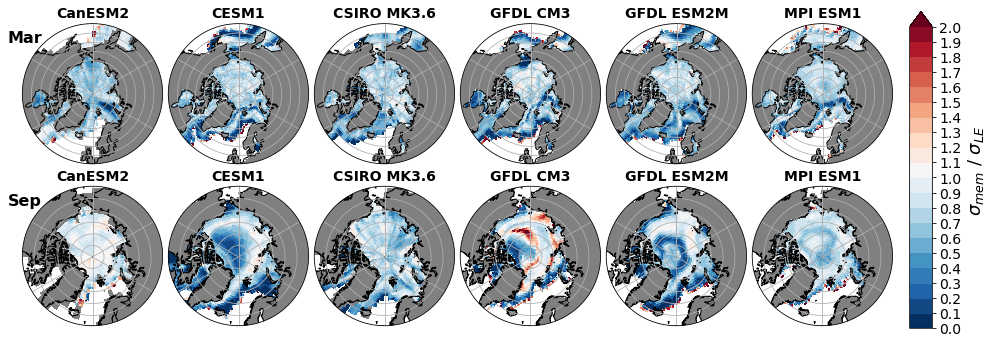

In [32]:
#difference LE - mem
# two_by_six_plots(mem_LE, masks_copied, 'RdBu_r', np.arange(-2,2.01,0.1), np.arange(-2,2.01,0.25), '$\sigma_{mem} - \sigma_{LE}$', 
#                  signif=[sigma_LE_03, sigma_LE_09], extend_kw='max', save_name='Resampled_figures_SIC_LE_mem_diff_sig') #don't use 0.001 offset for CSIRO rounding errors as corrected in .where != 0 now 
#ratio mem / LE
two_by_six_plots(mem_LE, masks_copied, 'RdBu_r', np.arange(0,2.01,0.1), np.arange(0,2.01,0.1), '$\sigma_{mem} \ / \ \sigma_{LE}$', 
                 extend_kw='max', save_name='Resampled_figures_SIC_LE_mem_ratio_median_no_lines') #use 0.001 offset for CSIRO rounding errors

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Ad

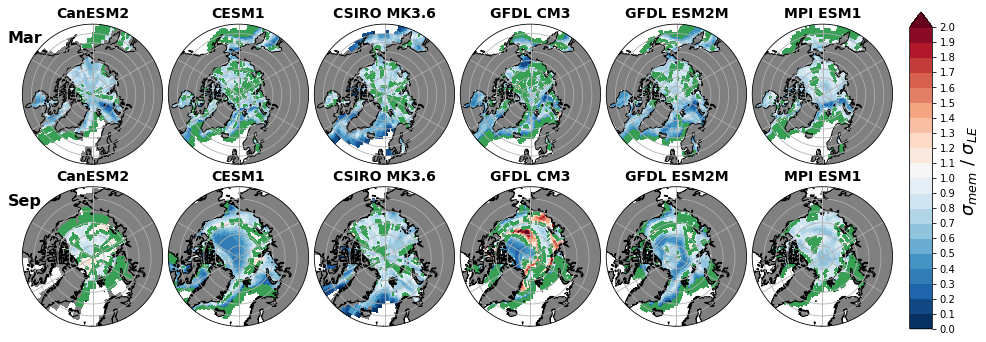

In [135]:
two_by_six_plots(mem_LE, masks_copied, 'RdBu_r', np.arange(0,2.01,0.1), np.arange(0,2.01,0.1), '$\sigma_{mem} \ / \ \sigma_{LE}$', 
                 signif=[sigma_LE_03, sigma_LE_09], extend_kw='max')

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Ad

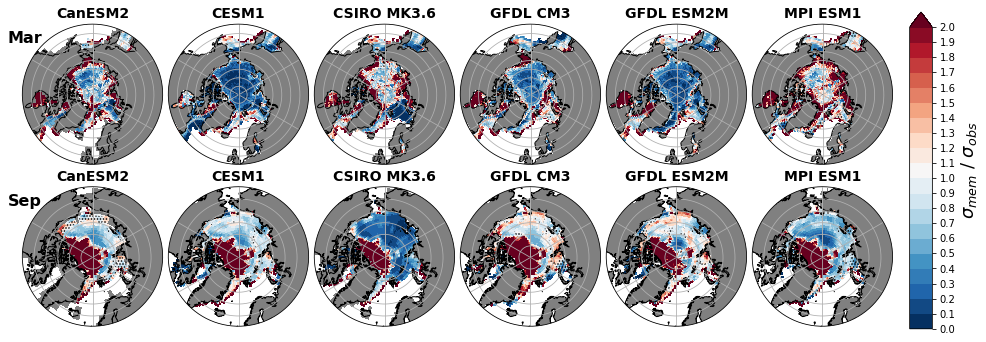

In [124]:
two_by_six_plots(mem_obs_CDR, masks_copied, 'RdBu_r', np.arange(0,2.01,0.1), np.arange(0,2.01,0.1), '$\sigma_{mem} \ / \ \sigma_{obs}$', 
                   signif=[sigma_obs_CDR_03, sigma_obs_CDR_09], extend_kw='max')#, save_name='Resampled_figures_SIC_obs_HadISST1_mem_ratio')

# Min and Max $\sigma_{obs}$, $\bar{\sigma}_{mem}$

In [6]:
CDR = xr.open_dataset(data_path+'SIC/Resampled/NSIDC_CDR_resampled_adj_individual_1979_2020_03_09_regrid.nc')
NT  = xr.open_dataset(data_path+'SIC/Resampled/NSIDC_NT_resampled_adj_individual_1979_2020_03_09_regrid.nc')
BT  = xr.open_dataset(data_path+'SIC/Resampled/NSIDC_BT_resampled_adj_individual_1979_2020_03_09_regrid.nc')
HadISST1 = xr.open_dataset(data_path+'SIC/Resampled/HadISST1_resampled_adj_individual_1979_2020_03_09_regrid.nc')

In [7]:
sigma_obs_min = xr.ufuncs.minimum(xr.ufuncs.minimum(CDR, NT), xr.ufuncs.minimum(BT, HadISST1))
sigma_obs_max = xr.ufuncs.maximum(xr.ufuncs.minimum(CDR, NT), xr.ufuncs.maximum(BT, HadISST1))

In [69]:
#sigma_obs min and max, bar_sigma_mem
sigma_mem_obs_min = []
sigma_mem_obs_max = []
sigma_mem_min = []
sigma_mem_max = []
sigma_mem_median = []
sigma_obs_min_list = []
sigma_obs_max_list = []
obs_uncertainty_abs = []
obs_uncertainty_ratio = []

for month_ in [3,9]:
    #find minimum sigma_obs
    sigma_obs_min = xr.ufuncs.minimum(xr.ufuncs.minimum(CDR, NT), xr.ufuncs.minimum(BT, HadISST1))*100
    sigma_obs_max = xr.ufuncs.maximum(xr.ufuncs.minimum(CDR, NT), xr.ufuncs.maximum(BT, HadISST1))*100
    
    for model_i, model_name in enumerate(model_names):
        adj_ind = xr.open_dataset(data_path+'SIC/Resampled/{}_resampled_{}_adj_individual_regrid.nc'.format(model_name, str(month_).zfill(2)))
        sigma_mem_obs_min.append(adj_ind['SD'].median('member')/sigma_obs_min['SD'].sel(month=month_))
        sigma_mem_obs_max.append(adj_ind['SD'].median('member')/sigma_obs_max['SD'].sel(month=month_))
        obs_uncertainty_abs.append(sigma_obs_max['SD'].sel(month=month_)-sigma_obs_min['SD'].sel(month=month_))
        obs_uncertainty_ratio.append(sigma_obs_max['SD'].sel(month=month_)/sigma_obs_min['SD'].sel(month=month_))
        
        sigma_mem_min.append(adj_ind['SD'].min('member'))
        sigma_mem_max.append(adj_ind['SD'].max('member'))
        sigma_mem_median.append(adj_ind['SD'].median('member'))
        sigma_obs_min_list.append(sigma_obs_min['SD'].sel(month=month_))
        sigma_obs_max_list.append(sigma_obs_max['SD'].sel(month=month_))
        

In [26]:
def two_by_six_plots_no_cbar(data, masks, colors, levels_, title_, save_name=False):
        
    fig = plt.figure(figsize=[15.8,5.5])
    
    for i in range(12):
        if type(data[i]) != str:
            if i < 6: #march
                lat_min = 50
                sig_i = 0
            else: #september
                lat_min = 60
                sig_i = 1

            ax = fig.add_subplot(2,6,i+1, projection = ccrs.NorthPolarStereo(central_longitude=0))
            ax.set_extent((-180,180,int(lat_min),90), ccrs.PlateCarree())

            theta = np.linspace(0, 2*np.pi, 100) #make the plot circular
            center, radius = [0.5, 0.5], 0.5
            verts = np.vstack([np.sin(theta), np.cos(theta)]).T
            circle = mpath.Path(verts * radius + center)
            ax.set_boundary(circle, transform=ax.transAxes)

            if masks:
                data_i = data[i].where(masks[model_names[i%6]]>-9)
            else:
                data_i = data[i]
            
            masks[model_names[i%6]].plot(ax=ax, cmap='binary', transform=ccrs.PlateCarree(), levels=np.arange(-0.01, 100, 1), add_colorbar=False)
            
            plotting = data_i.where(data_i!=0).plot(ax=ax, cmap=str(colors), add_colorbar=False, transform=ccrs.PlateCarree(), levels=levels_, add_labels=False)

            ax.coastlines()
            ax.gridlines()
            ax.set_title(model_print_names[i%6], fontsize=14, fontweight='bold')
            ax.set_facecolor('0.5')

            if i == 0:
                ax.text(0.14, 0.95, 'Mar', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right');
            elif i == 6:
                ax.text(0.14, 0.95, 'Sep', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right');
            elif i == 5:
                ax.text(1, 0, title_, fontsize=24,fontweight='bold', transform=ax.transAxes, va='center', ha='left', rotation=90)
    
    fig.subplots_adjust(top=0.99, hspace=-0.1, wspace=0.04)
    fig.tight_layout()
    
    if save_name:
        fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIC/figures/{}.pdf'.format(save_name), bbox_inches = 'tight', pad_inches = 0)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


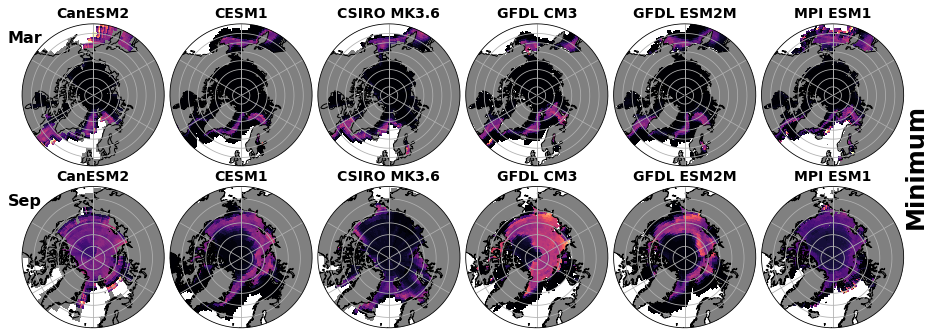

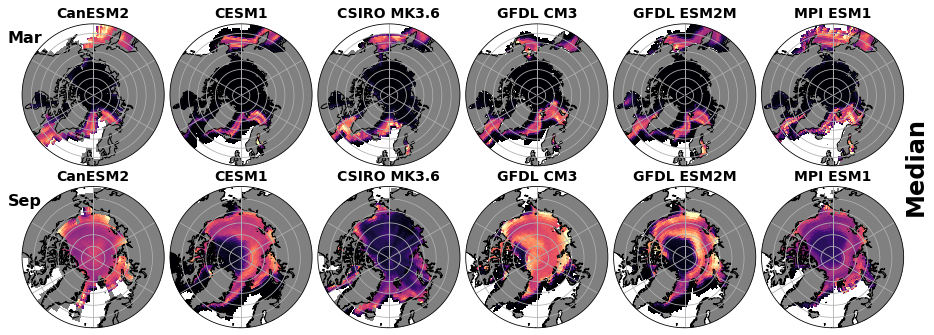

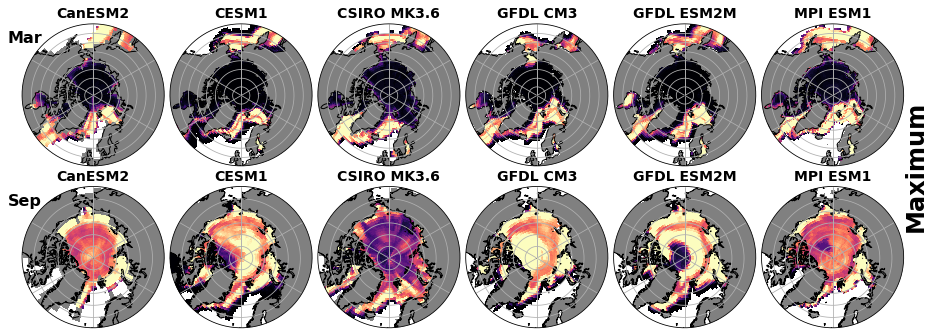

In [31]:
two_by_six_plots_no_cbar(sigma_mem_min, masks_copied, 'magma', np.arange(0,5.01,0.1), 'Minimum', save_name='Resampled_figures_SIC_mem_min')
two_by_six_plots_no_cbar(sigma_mem_median, masks_copied, 'magma', np.arange(0,5.01,0.1), 'Median', save_name='Resampled_figures_SIC_mem_median')
two_by_six_plots_no_cbar(sigma_mem_max, masks_copied, 'magma', np.arange(0,5.01,0.1), 'Maximum', save_name='Resampled_figures_SIC_mem_max')

In [ ]:
def two_by_four_plots(data, mask, colors, levels_, cbar_levels_, cbar_label, extend_kw=False, save_name=False):
           
    fig = plt.figure(figsize=[11,5.5])
    
    for i in range(8):
        if type(data[i]) != str:
            if i < 4: #march
                lat_min = 50
                sig_i = 0
            else: #september
                lat_min = 60
                sig_i = 1

            ax = fig.add_subplot(2,4,i+1, projection = ccrs.NorthPolarStereo(central_longitude=0))
            ax.set_extent((-180,180,int(lat_min),90), ccrs.PlateCarree())

            theta = np.linspace(0, 2*np.pi, 100) #make the plot circular
            center, radius = [0.5, 0.5], 0.5
            verts = np.vstack([np.sin(theta), np.cos(theta)]).T
            circle = mpath.Path(verts * radius + center)
            ax.set_boundary(circle, transform=ax.transAxes)
          
            if masks:
                data_i = data[i].where(masks[model_names[i%6]]>-9)
            else:
                data_i = data[i]
            
            masks[model_names[i%6]].plot(ax=ax, cmap='binary', transform=ccrs.PlateCarree(), levels=np.arange(-0.01, 100, 1), add_colorbar=False)
            
            plotting = data_i.where(data_i!=0).plot(ax=ax, cmap=str(colors), add_colorbar=False, transform=ccrs.PlateCarree(), levels=levels_, add_labels=False)

            ax.coastlines()
            ax.gridlines()
            ax.set_title(dataset_print_names[i%4], fontsize=14, fontweight='bold')
            ax.set_facecolor('0.5')


            if i == 0:
                ax.text(0.14, 0.95, 'Mar', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right');
            elif i == 4:
                ax.text(0.14, 0.95, 'Sep', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right');

                fig.subplots_adjust(right=0.89)
                
        cbar_ax = fig.add_axes([0.905, 0.17, 0.03, 0.8])
    
    if extend_kw:
        cb = fig.colorbar(plotting, cax=cbar_ax, ticks=cbar_levels_, spacing='uniform', extend=extend_kw, orientation='vertical')
    else:
        cb = fig.colorbar(plotting, cax=cbar_ax, ticks=cbar_levels_, spacing='uniform', extend='both', orientation='vertical')
    
    cb.ax.set_ylabel(str(cbar_label), fontsize=26, color='0') 
    cbtick_obj = plt.getp(cb.ax.axes, 'yticklabels')   
    plt.setp(cbtick_obj, color='0', fontsize=14)
    
    fig.subplots_adjust(top=0.99, hspace=-0.06, wspace=0.04)
    fig.tight_layout()
    
    if save_name:
        fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIC/figures/{}.pdf'.format(save_name), bbox_inches = 'tight', pad_inches = 0)
        fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIC/figures/{}.png'.format(save_name), dpi=400, bbox_inches = 'tight', pad_inches = 0)

In [14]:
#all sigma_obs
sigma_obs_each_dataset = []

for month_ in [3,9]:
    for dataset_name in dataset_names:
        if dataset_name != 'Merged_Hadley_OI':
            data = xr.open_dataset(data_path+'SIC/Resampled/{}_resampled_adj_individual_1979_2020_03_09_regrid.nc'.format(dataset_name))
            sigma_obs_each_dataset.append(data['SD'].sel(month=month_)*100)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Ad

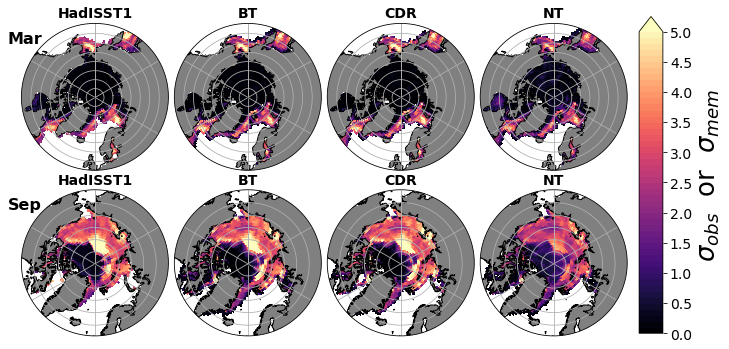

In [33]:
two_by_four_plots(sigma_obs_each_dataset, masks_copied['CESM1'], 'magma', np.arange(0,5.01,0.1), np.arange(0,5.01,0.5), r'$\sigma_{obs}$'+'  or  '+r'$\sigma_{mem}$', extend_kw='max', save_name='Resampled_figures_SIC_obs')

# September or March min,median,max

In [7]:
#load all the data for march or september
#sigma_obs min and max, bar_sigma_mem
month_ = 9
data_month = []

for stat in range(3):
    for model_i, model_name in enumerate(model_names):
        adj_ind = xr.open_dataset(data_path+'SIC/Resampled/{}_resampled_{}_adj_individual_regrid.nc'.format(model_name, str(month_).zfill(2)))

        if stat == 0:
            data_month.append(adj_ind['SD'].max('member'))
        elif stat == 1:
            data_month.append(adj_ind['SD'].median('member'))
        elif stat == 2:
            data_month.append(adj_ind['SD'].min('member'))

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


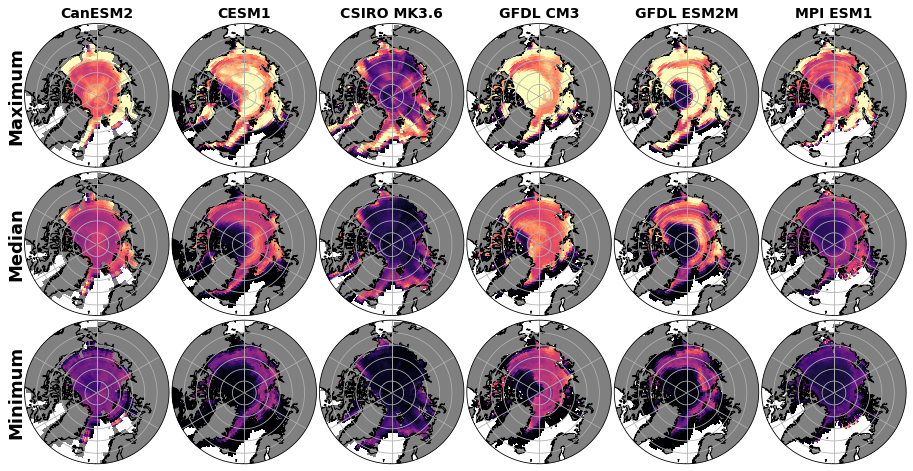

In [8]:
lat_min = 60
colors = 'magma'
levels_ = np.arange(0,5.01,0.1)

fig = plt.figure(figsize=[15.8,7.5])
data = data_month.copy()

for i in range(18):

    ax = fig.add_subplot(3,6,i+1, projection = ccrs.NorthPolarStereo(central_longitude=0))
    ax.set_extent((-180,180,int(lat_min),90), ccrs.PlateCarree())

    theta = np.linspace(0, 2*np.pi, 100) #make the plot circular
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    if masks:
        data_i = data[i].where(masks_copied[model_names[i%6]]>-9)
    else:
        data_i = data[i]

    masks_copied[model_names[i%6]].plot(ax=ax, cmap='binary', transform=ccrs.PlateCarree(), levels=np.arange(-0.01, 100, 1), add_colorbar=False, linewidths=0.0000000001, edgecolors='face')

    plotting = data_i.where(data_i!=0).plot(ax=ax, cmap=str(colors), add_colorbar=False, transform=ccrs.PlateCarree(), levels=levels_, add_labels=False, linewidths=0.0000000001, edgecolors='face')

    ax.coastlines()
    ax.gridlines()
    if i <6:
        ax.set_title(model_print_names[i%6], fontsize=14, fontweight='bold')
    ax.set_facecolor('0.5')

    if i == 0:
        ax.text(-0.12, 0.5, 'Maximum', fontsize=18,fontweight='bold', transform=ax.transAxes, va='center', ha='left', rotation=90)
    elif i == 6:
        ax.text(-0.12, 0.5, 'Median', fontsize=18,fontweight='bold', transform=ax.transAxes, va='center', ha='left', rotation=90)
    elif i == 12:
        ax.text(-0.12, 0.5, 'Minimum', fontsize=18,fontweight='bold', transform=ax.transAxes, va='center', ha='left', rotation=90)

fig.subplots_adjust(top=0.99, hspace=-0.13, wspace=0.02)
fig.tight_layout()


fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIC/figures/Sigma_mem_min_max_median_09_no_lines.pdf', bbox_inches = 'tight', pad_inches = 0)

## $\sigma_{obs}$ single month

In [13]:
sigma_obs_month = []
month_ = 3
for dataset_name in dataset_names:
    if dataset_name != 'Merged_Hadley_OI':
        data = xr.open_dataset(data_path+'SIC/Resampled/{}_resampled_adj_individual_1979_2020_03_09_regrid.nc'.format(dataset_name))
        sigma_obs_month.append(data['SD'].sel(month=month_)*100)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


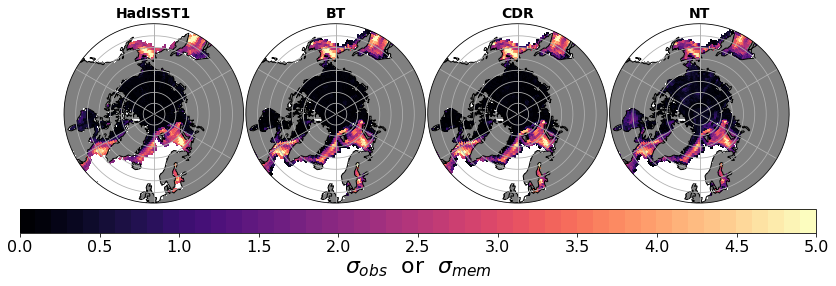

In [15]:
lat_min = 50
data = sigma_obs_month
colors = 'magma'
levels_ = np.arange(0,5.01,0.1)
cbar_levels_ = np.arange(0,5.01,0.5)
cbar_label = r'$\sigma_{obs}$'+'  or  '+r'$\sigma_{mem}$'

fig = plt.figure(figsize=[15.8,3.3])

for i in range(4):
    
    ax = fig.add_subplot(1,4,i+1, projection = ccrs.NorthPolarStereo(central_longitude=0))
    ax.set_extent((-180,180,int(lat_min),90), ccrs.PlateCarree())

    theta = np.linspace(0, 2*np.pi, 100) #make the plot circular
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    if masks:
        data_i = data[i].where(masks_copied['CESM1']>-9)
    else:
        data_i = data[i]

    masks_copied['CESM1'].plot(ax=ax, cmap='binary', transform=ccrs.PlateCarree(), levels=np.arange(-0.01, 100, 1), add_colorbar=False, linewidths=0.0000000001, edgecolors='face')

    plotting = data_i.where(data_i!=0).plot(ax=ax, cmap=str(colors), add_colorbar=False, transform=ccrs.PlateCarree(), levels=levels_, add_labels=False, linewidths=0.0000000001, edgecolors='face')

    ax.coastlines()
    ax.gridlines()
    ax.set_title(dataset_print_names[i%4], fontsize=14, fontweight='bold')
    ax.set_facecolor('0.5')
    fig.subplots_adjust(right=0.89)

cbar_ax = fig.add_axes([0.15, 0, 0.7, 0.1])
cb = fig.colorbar(plotting, cax=cbar_ax, ticks=cbar_levels_, spacing='uniform', extend='neither', orientation='horizontal')
cb.ax.set_xlabel(str(cbar_label), fontsize=22, color='0') 
cbtick_obj = plt.getp(cb.ax.axes, 'xticklabels')   
plt.setp(cbtick_obj, color='0', fontsize=16)

fig.subplots_adjust(wspace=-0.44)
fig.tight_layout()

fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIC/figures/Sigma_obs_03_no_lines.pdf', bbox_inches = 'tight', pad_inches = 0)

# Consistency

In [136]:
# #plot example of envalope of members and observations
# mean_SD = 'SD'
# month_ = 9
# model_name = 'MPI_ESM1'
# i = -6

# sigma_mem = xr.open_dataset(data_path+'SIC/Resampled/{}_resampled_0{}_adj_individual_regrid.nc'.format(model_name, month_))
# sigma_mem = sigma_mem[mean_SD]

# for obs_data in ['NSIDC_CDR','HadISST1']:
#     print(obs_data)
#     sigma_obs = xr.open_dataset(data_path+'SIC/Resampled/{}_resampled_adj_individual_1979_2020_03_09_regrid.nc'.format(obs_data))
#     sigma_obs = sigma_obs[mean_SD].sel(month=month_)*100


#     sigma_obs.isel(lat=i).plot(label=obs_data, c='r')
#     plt.fill_between(sigma_mem['lon'], sigma_mem.min('member').isel(lat=i), sigma_mem.max('member').isel(lat=i),
#                      facecolor='b', edgecolor='face', alpha=0.4)

# plt.yscale('log')
# plt.legend()
# plt.title(model_name+', March, 84.9 N');

### Caclulate inconsistent areas and combine

In [16]:
# def calc_inconsistent(mean_SD, obs_data, threshold):
#     'Calculates whether there is at least one members overlapping with observations'
    
#     too_high_flag_all  = []
#     too_low_flag_all   = []
#     no_sea_ice_all = []
#     for model_name in model_names:

#         too_high_flag = []
#         too_low_flag  = []
#         no_sea_ice = []
#         for month_ in [3,9]:

#             #load either the average across resamplings or the SD across resamplings of SD(time)
#             sigma_mem = xr.open_dataset(data_path+'SIC/Resampled/{}_resampled_0{}_adj_individual_regrid.nc'.format(model_name, month_))
#             sigma_mem = sigma_mem[mean_SD]

#             if model_name == 'CSIRO_MK36': sigma_mem = sigma_mem.where(sigma_mem>1e-10,0) #CSIRO has e-11 rather than nans

#             sigma_obs = xr.open_dataset(data_path+'SIC/Resampled/{}_resampled_adj_individual_1979_2020_03_09_regrid.nc'.format(obs_data))
#             sigma_obs = sigma_obs[mean_SD].sel(month=month_)*100
#             #create an array of ones of the shape of the lat/lon grid
#             ones_array = xr.DataArray(data   = np.ones([len(sigma_obs['lat']),len(sigma_obs['lon'])]),
#                                       coords = {'lat':sigma_obs['lat'], 'lon':sigma_obs['lon']},
#                                       dims   = {'lat':sigma_obs['lat'], 'lon':sigma_obs['lon']})

#             #find the difference of the minimum and maximum values from observations 
#             mins = sigma_mem.min('member') - (sigma_obs)*(1+threshold) #negative number is good
#             maxs = sigma_mem.max('member') - (sigma_obs)*(1-threshold) #positive number is good

#             #too_high_flag = 1: bad, all model members too high. too_high_flag = 0: good, at least one member below obs
#             #too_low_flag  = 1: bad, all model members too low.  too_high_flag = 0: good, at least one member above obs
#             too_high_flag.append(ones_array.copy().where(mins > 0, 0))
#             too_low_flag.append(ones_array.copy().where(maxs < 0, 0))
            
            
#             ##### find regions where no sea ice exists (or pole hole)
#             no_sea_ice_mem = sigma_mem.mean('member').where(sigma_mem.mean('member')>-1,-1)
#             no_sea_ice_mem = no_sea_ice_mem.where(no_sea_ice_mem==-1,0)
            
#             no_sea_ice_obs = sigma_obs.where(sigma_obs>-1,-1)
#             no_sea_ice_obs = no_sea_ice_obs.where(no_sea_ice_obs==-1,0)

#             no_sea_ice_both = xr.ufuncs.logical_or(no_sea_ice_obs, no_sea_ice_mem)
#             no_sea_ice.append(no_sea_ice_both.where(no_sea_ice_both==1,0))

        
#         too_high_flag_all.append(xr.concat((too_high_flag), dim='month'))
#         too_low_flag_all.append(xr.concat((too_low_flag), dim='month'))
#         no_sea_ice_all.append(xr.concat((no_sea_ice), dim='month'))
           
#     too_high_flag_all = xr.concat((too_high_flag_all), dim='model')
#     too_high_flag_all['model'] = model_names
#     too_high_flag_all['month'] = [3,9]
        
#     too_low_flag_all = xr.concat((too_low_flag_all), dim='model')
#     too_low_flag_all['model'] = model_names
#     too_low_flag_all['month'] = [3,9]
    
#     no_sea_ice_all = xr.concat((no_sea_ice_all), dim='model')
#     no_sea_ice_all['model'] = model_names
#     no_sea_ice_all['month'] = [3,9]
    
#     return too_high_flag_all, too_low_flag_all, no_sea_ice_all

In [84]:
# # run the inconsistent calculations
# CDR_SD = calc_inconsistent('SD', 'NSIDC_CDR', 0)
# CDR_mean = calc_inconsistent('mean', 'NSIDC_CDR', 0)
# # CDR_SD = calc_inconsistent('SD', 'NSIDC_NT', 0)
# # CDR_mean = calc_inconsistent('mean', 'NSIDC_NT', 0)

# Had_SD = calc_inconsistent('SD', 'HadISST1', 0)
# Had_mean = calc_inconsistent('mean', 'HadISST1', 0)

# #compute subsequent calculations
# red_CDR = CDR_SD[0] * CDR_mean[0]
# red_Had = Had_SD[0] * Had_mean[0]

# blue_CDR = CDR_SD[1] * CDR_mean[1]
# blue_Had = Had_SD[1] * Had_mean[1]

# black_CDR = (red_CDR + blue_CDR).where((red_CDR + blue_CDR)==2,0)
# black_Had = (red_Had + blue_Had).where((red_Had + blue_Had)==2,0)

# red_both  = (red_CDR+red_Had).where((red_CDR+red_Had)==2,0)/2
# blue_both = (blue_CDR+blue_Had).where((blue_CDR+blue_Had)==2,0)/2

# red_disagree  = (red_CDR+red_Had).where((red_CDR+red_Had)==1,0)
# blue_disagree = (blue_CDR+blue_Had).where((blue_CDR+blue_Had)==1,0)
# black_both = xr.ufuncs.logical_not(xr.ufuncs.isnan((red_disagree + blue_disagree).where((red_disagree + blue_disagree)>0)))

# no_ice_both = xr.ufuncs.logical_not(xr.ufuncs.isnan((CDR_SD[2] + Had_SD[2]).where((CDR_SD[2] + Had_SD[2])>0)))

# #make lists for iterating through when plotting
# red_list    = [red_CDR, red_Had, red_both]
# blue_list   = [blue_CDR, blue_Had, blue_both]
# black_list  = [black_CDR, black_Had, black_both]
# no_ice_list = [CDR_SD[2], Had_SD[2], no_ice_both]

In [87]:
# model_names_center = ['   CanESM2', 
#                       '     CESM1', 
#                       ' CSIRO MK36',
#                       '  GFDL CM3',
#                       'GFDL ESM2M', 
#                       '  MPI ESM1']

# titles_datasets = ['        CDR', '      HadISST1', '          Both']

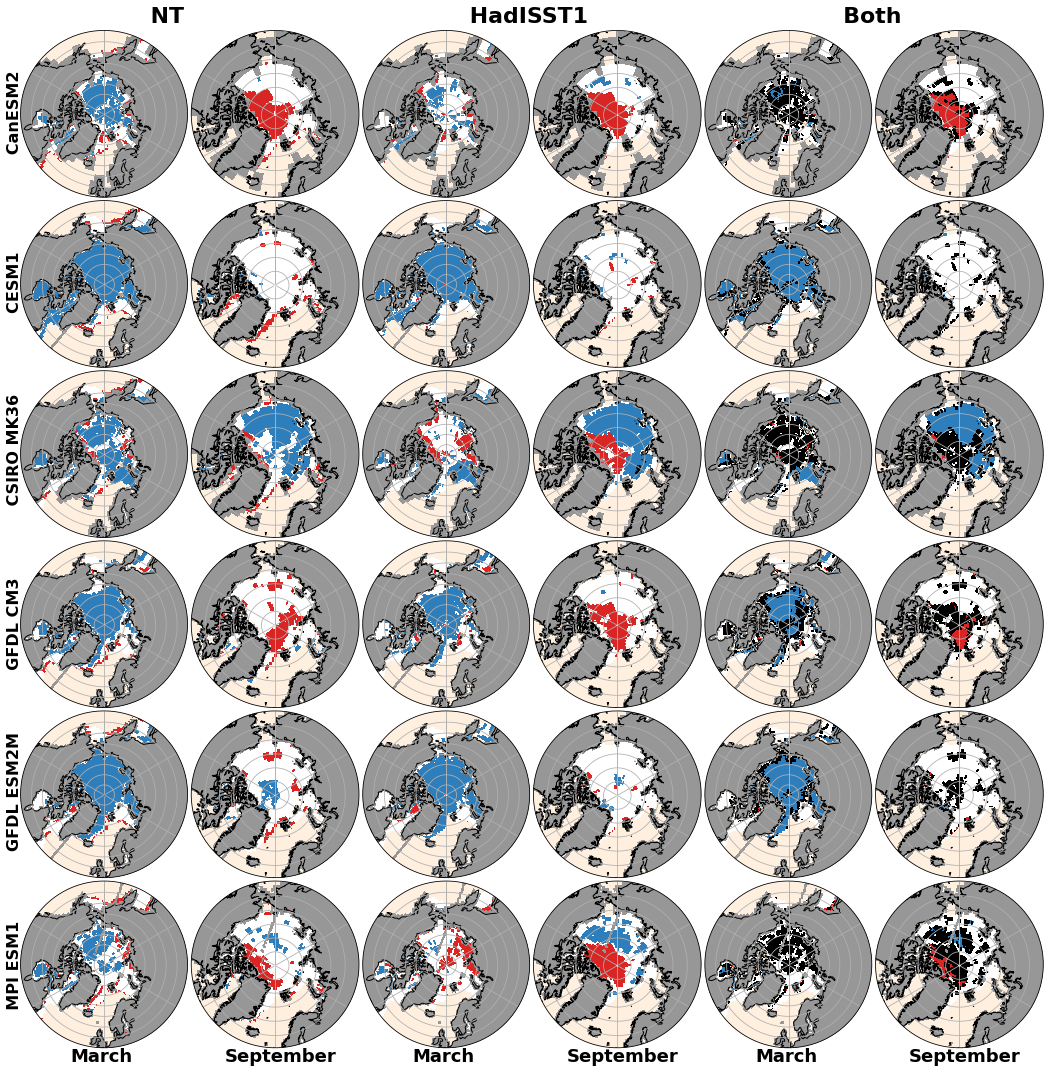

In [86]:
# #plot 6x6
# fig = plt.figure(figsize=[18,18])

# for dataset in range(3):
    
#     for model_i, model_name in enumerate(model_names):
#         for month_i, month_ in enumerate([3,9]):

#             i = (model_i*2) + month_i + 1
#             if month_ == 3:
#                 lat_min = 50
#             else:
#                 lat_min = 60

#             ax = fig.add_subplot(6,6,i+(model_i*4 + dataset*2), projection = ccrs.NorthPolarStereo(central_longitude=0))
#             ax.set_extent((-180,180,lat_min,90), ccrs.PlateCarree())

#             #set boundary of subplots
#             theta = np.linspace(0, 2*np.pi, 100) #make the plot circular
#             center, radius = [0.5, 0.5], 0.5
#             verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#             circle = mpath.Path(verts * radius + center)
#             ax.set_boundary(circle, transform=ax.transAxes)
#             ax.set_facecolor('1')
            
#             #plot in sequence: red (too high), blue (too low), black (disagreement), baige (no sea ice), gray (land)
#             #red - too high
#             red_list[dataset].sel(model=model_name).sel(month=month_).plot(cmap='Reds', levels=np.arange(0.2,1.4,0.1), add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither')
#             #blue - too low
#             blue_list[dataset].sel(model=model_name).sel(month=month_).plot(cmap='Blues', levels=np.arange(0.2,1.4,0.1), add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither')
#             #black - disagreement
#             black_list[dataset].sel(model=model_name).sel(month=month_).plot(cmap='binary', levels=np.arange(0.9,1.11,0.1), add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither')            
#             #baige - no sea ice 
#             no_ice_list[dataset].sel(model=model_name).sel(month=month_).plot(cmap='Oranges', levels=np.arange(0.9,3,0.1), add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither')
#             #gray - land 
#             xr.ufuncs.isnan(masks_copied[model_name]).plot(cmap='binary', levels=np.arange(0.1,2.5,0.1), add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither')
            
#             ax.coastlines()
#             ax.gridlines()

#             if i == 1:    
#                 ax.text(0.37, 1.14, titles_datasets[dataset], fontsize=22, fontweight='bold', transform=ax.transAxes, va='top', ha='left');
#             elif i == 12:
#                 ax.text(0.2, 0, 'September', fontsize=18, fontweight='bold', transform=ax.transAxes, va='top', ha='left');
#             elif i == 11:
#                 ax.text(0.3, 0, 'March', fontsize=18, fontweight='bold', transform=ax.transAxes, va='top', ha='left');
            
#             if (i+(model_i*4 + dataset*2)-1) % 6 == 0:
#                 ax.text(-0.08, 0.16, model_names_center[model_i], fontsize=16, fontweight='bold', transform=ax.transAxes, va='bottom', ha='left', rotation='vertical');
                

# fig.subplots_adjust(top=0.91, left=0.02, hspace=0.02, wspace=-0.4);
# # fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIC/figures/Resampled_figures_SIC_Consistency_6x6.pdf', bbox_inches = 'tight', pad_inches = 0)
# # fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIC/figures/Resampled_figures_SIC_Consistency_6x6.png', bbox_inches = 'tight', pad_inches = 0, dpi=300)

# Maximum and minimum $\sigma_{obs}$

In [4]:
def calc_inconsistent_max_min_obs(mean_SD, obs_03, obs_09, threshold):
    'Calculates whether there is at least one members overlapping with observations'
    
    too_high_flag_all  = []
    too_low_flag_all   = []
    no_sea_ice_all = []
    for model_name in model_names:

        too_high_flag = []
        too_low_flag  = []
        no_sea_ice = []
        for month_ in [3,9]:

            #load either the average across resamplings or the SD across resamplings of SD(time)
            sigma_mem = xr.open_dataset(data_path+'SIC/Resampled/{}_resampled_0{}_adj_individual_regrid.nc'.format(model_name, month_))
            sigma_mem = sigma_mem[mean_SD]

            if model_name == 'CSIRO_MK36': sigma_mem = sigma_mem.where(sigma_mem>1e-10,0) #CSIRO has e-11 rather than nans

            if month_ == 3:
                sigma_obs = obs_03
            else:
                sigma_obs = obs_09
            #create an array of ones of the shape of the lat/lon grid
            ones_array = xr.DataArray(data   = np.ones([len(sigma_obs['lat']),len(sigma_obs['lon'])]),
                                      coords = {'lat':sigma_obs['lat'], 'lon':sigma_obs['lon']},
                                      dims   = {'lat':sigma_obs['lat'], 'lon':sigma_obs['lon']})

            #find the difference of the minimum and maximum values from observations 
            mins = sigma_mem.min('member') - (sigma_obs)*(1+threshold) #negative number is good
            maxs = sigma_mem.max('member') - (sigma_obs)*(1-threshold) #positive number is good

            #too_high_flag = 1: bad, all model members too high. too_high_flag = 0: good, at least one member below obs
            #too_low_flag  = 1: bad, all model members too low.  too_high_flag = 0: good, at least one member above obs
            too_high_flag.append(ones_array.copy().where(mins > 0, 0))
            too_low_flag.append(ones_array.copy().where(maxs < 0, 0))
            
            
            ##### find regions where no sea ice exists (or pole hole)
            no_sea_ice_mem = sigma_mem.mean('member').where(sigma_mem.mean('member')>-1,-1)
            no_sea_ice_mem = no_sea_ice_mem.where(no_sea_ice_mem==-1,0)
            
            no_sea_ice_obs = sigma_obs.where(sigma_obs>-1,-1)
            no_sea_ice_obs = no_sea_ice_obs.where(no_sea_ice_obs==-1,0)

            no_sea_ice_both = xr.ufuncs.logical_or(no_sea_ice_obs, no_sea_ice_mem)
            no_sea_ice.append(no_sea_ice_both.where(no_sea_ice_both==1,0))

        
        too_high_flag_all.append(xr.concat((too_high_flag), dim='month'))
        too_low_flag_all.append(xr.concat((too_low_flag), dim='month'))
        no_sea_ice_all.append(xr.concat((no_sea_ice), dim='month'))
           
    too_high_flag_all = xr.concat((too_high_flag_all), dim='model')
    too_high_flag_all['model'] = model_names
    too_high_flag_all['month'] = [3,9]
        
    too_low_flag_all = xr.concat((too_low_flag_all), dim='model')
    too_low_flag_all['model'] = model_names
    too_low_flag_all['month'] = [3,9]
    
    no_sea_ice_all = xr.concat((no_sea_ice_all), dim='model')
    no_sea_ice_all['model'] = model_names
    no_sea_ice_all['month'] = [3,9]
    
    return too_high_flag_all, too_low_flag_all, no_sea_ice_all

In [5]:
#all sigma_obs
sigma_obs_03 = []
sigma_obs_09 = []
mu_obs_03 = []
mu_obs_09 = []

for dataset_name in dataset_names:
    if dataset_name != 'Merged_Hadley_OI':
        data = xr.open_dataset(data_path+'SIC/Resampled/{}_resampled_adj_individual_1979_2020_03_09_regrid.nc'.format(dataset_name))
        sigma_obs_03.append(data['SD'].sel(month=3)*100)
        sigma_obs_09.append(data['SD'].sel(month=9)*100)
        
        mu_obs_03.append(data['mean'].sel(month=3)*100)
        mu_obs_09.append(data['mean'].sel(month=9)*100)

In [6]:
sigma_obs_03_xr = xr.concat((sigma_obs_03),dim='dataset')
sigma_obs_09_xr = xr.concat((sigma_obs_09),dim='dataset')
mu_obs_03_xr = xr.concat((mu_obs_03),dim='dataset')
mu_obs_09_xr = xr.concat((mu_obs_09),dim='dataset')

In [10]:
# # run the inconsistent calculations
# CDR_SD = calc_inconsistent_max_min_obs('SD', sigma_obs_03_xr.min('dataset'),  sigma_obs_09_xr.min('dataset'), 0)
# CDR_mean = calc_inconsistent_max_min_obs('mean', mu_obs_03_xr.min('dataset'),  mu_obs_09_xr.min('dataset'), 0)

# Had_SD = calc_inconsistent_max_min_obs('SD', sigma_obs_03_xr.max('dataset'),  sigma_obs_09_xr.max('dataset'), 0)
# Had_mean = calc_inconsistent_max_min_obs('mean', mu_obs_03_xr.max('dataset'),  mu_obs_09_xr.max('dataset'), 0)

# #compute subsequent calculations
# red_CDR = CDR_SD[0] * CDR_mean[0]
# red_Had = Had_SD[0] * Had_mean[0]

# blue_CDR = CDR_SD[1] * CDR_mean[1]
# blue_Had = Had_SD[1] * Had_mean[1]

# black_CDR = (red_CDR + blue_CDR).where((red_CDR + blue_CDR)==2,0)
# black_Had = (red_Had + blue_Had).where((red_Had + blue_Had)==2,0)

# red_both  = (red_CDR+red_Had).where((red_CDR+red_Had)==2,0)/2
# blue_both = (blue_CDR+blue_Had).where((blue_CDR+blue_Had)==2,0)/2

# red_disagree  = (red_CDR+red_Had).where((red_CDR+red_Had)==1,0)
# blue_disagree = (blue_CDR+blue_Had).where((blue_CDR+blue_Had)==1,0)
# black_both = xr.ufuncs.logical_not(xr.ufuncs.isnan((red_disagree + blue_disagree).where((red_disagree + blue_disagree)>0)))

# no_ice_both = xr.ufuncs.logical_not(xr.ufuncs.isnan((CDR_SD[2] + Had_SD[2]).where((CDR_SD[2] + Had_SD[2])>0)))

# #make lists for iterating through when plotting
# red_list    = [red_CDR, red_Had, red_both]
# blue_list   = [blue_CDR, blue_Had, blue_both]
# black_list  = [black_CDR, black_Had, black_both]
# no_ice_list = [CDR_SD[2], Had_SD[2], no_ice_both]

In [7]:
model_names_center = ['   CanESM2', 
                      '     CESM1', 
                      ' CSIRO MK36',
                      '  GFDL CM3',
                      'GFDL ESM2M', 
                      '  MPI ESM1']

titles_datasets = ['Minimum '+r'$\sigma_{obs}$'+' and '+r'$\mu_{obs}$', 'Maximum '+r'$\sigma_{obs}$'+' and '+r'$\mu_{obs}$', '     All '+r'$\sigma_{obs}$'+' and '+r'$\mu_{obs}$']

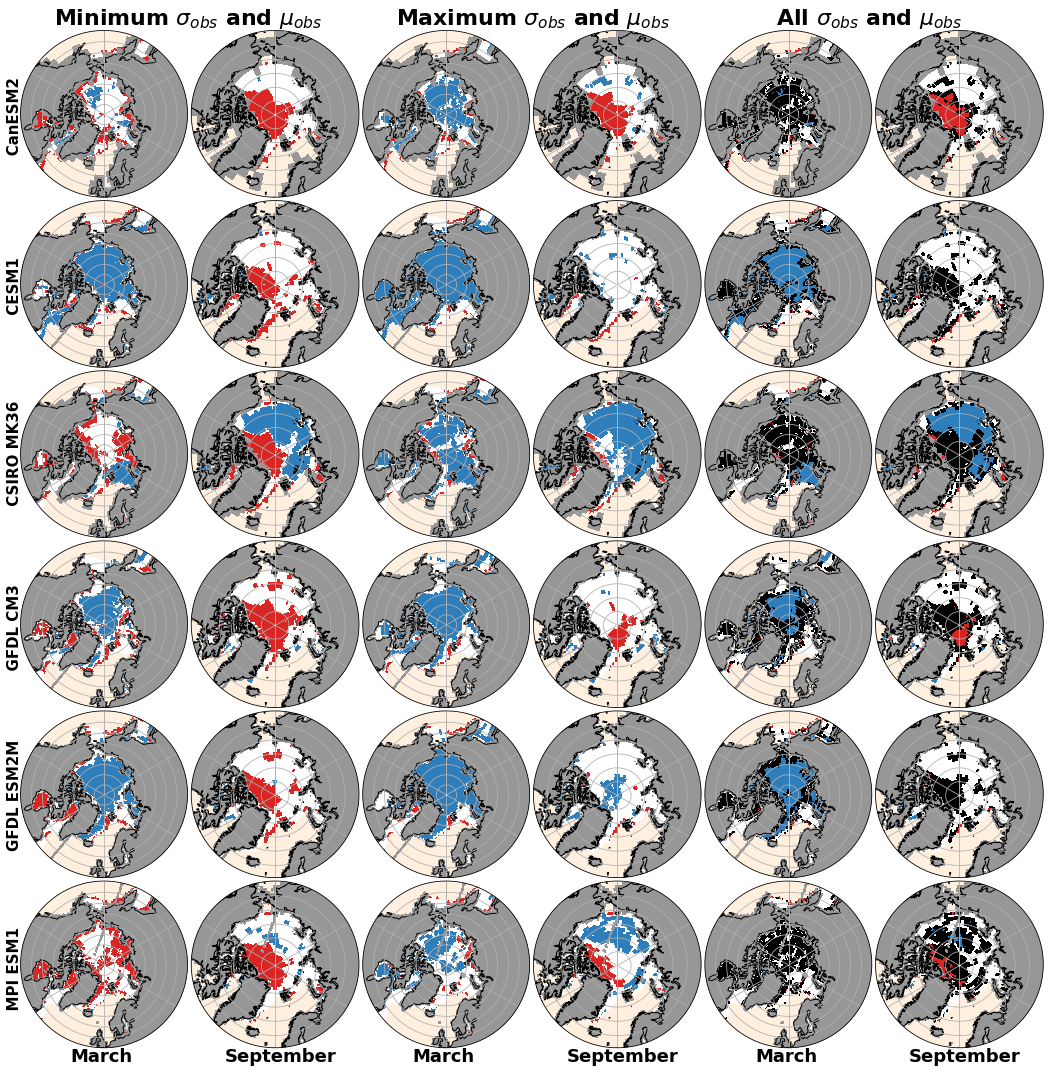

In [ ]:
# #plot 6x6
# fig = plt.figure(figsize=[18,18])

# for dataset in range(3):
    
#     for model_i, model_name in enumerate(model_names):
#         for month_i, month_ in enumerate([3,9]):

#             i = (model_i*2) + month_i + 1
#             if month_ == 3:
#                 lat_min = 50
#             else:
#                 lat_min = 60

#             ax = fig.add_subplot(6,6,i+(model_i*4 + dataset*2), projection = ccrs.NorthPolarStereo(central_longitude=0))
#             ax.set_extent((-180,180,lat_min,90), ccrs.PlateCarree())

#             #set boundary of subplots
#             theta = np.linspace(0, 2*np.pi, 100) #make the plot circular
#             center, radius = [0.5, 0.5], 0.5
#             verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#             circle = mpath.Path(verts * radius + center)
#             ax.set_boundary(circle, transform=ax.transAxes)
#             ax.set_facecolor('1')
            
#             #plot in sequence: red (too high), blue (too low), black (disagreement), baige (no sea ice), gray (land)
#             #red - too high
#             red_list[dataset].sel(model=model_name).sel(month=month_).plot(colors='Reds', levels=np.arange(0.2,1.4,0.1), add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither')
#             #blue - too low
#             blue_list[dataset].sel(model=model_name).sel(month=month_).plot(cmap='Blues', levels=np.arange(0.2,1.4,0.1), add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither')
#             #black - disagreement
#             black_list[dataset].sel(model=model_name).sel(month=month_).plot(cmap='binary', levels=np.arange(0.9,1.11,0.1), add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither')            
#             #baige - no sea ice 
#             no_ice_list[dataset].sel(model=model_name).sel(month=month_).plot(cmap='Oranges', levels=np.arange(0.9,3,0.1), add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither')
#             #gray - land 
#             xr.ufuncs.isnan(masks_copied[model_name]).plot(cmap='binary', levels=np.arange(0.1,2.5,0.1), add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither')
            
#             ax.coastlines()
#             ax.gridlines()

#             if i == 1:    
#                 ax.text(0.2, 1.14, titles_datasets[dataset], fontsize=22, fontweight='bold', transform=ax.transAxes, va='top', ha='left');
#             elif i == 12:
#                 ax.text(0.2, 0, 'September', fontsize=18, fontweight='bold', transform=ax.transAxes, va='top', ha='left');
#             elif i == 11:
#                 ax.text(0.3, 0, 'March', fontsize=18, fontweight='bold', transform=ax.transAxes, va='top', ha='left');
            
#             if (i+(model_i*4 + dataset*2)-1) % 6 == 0:
#                 ax.text(-0.08, 0.16, model_names_center[model_i], fontsize=15, fontweight='bold', transform=ax.transAxes, va='bottom', ha='left', rotation='vertical');
                

# fig.subplots_adjust(top=0.91, left=0.02, hspace=0.02, wspace=-0.4);
# # fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIC/figures/Resampled_figures_SIC_Consistency_6x6_min_max.pdf', bbox_inches = 'tight', pad_inches = 0)
# # fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIC/figures/Resampled_figures_SIC_Consistency_6x6_min_max.png', bbox_inches = 'tight', pad_inches = 0, dpi=300)

# Add in pink and light blue for only one of the metrics classify as inconsistent

In [8]:
# run the inconsistent calculations
min_SD = calc_inconsistent_max_min_obs('SD', sigma_obs_03_xr.min('dataset'),  sigma_obs_09_xr.min('dataset'), 0)
min_mean = calc_inconsistent_max_min_obs('mean', mu_obs_03_xr.min('dataset'),  mu_obs_09_xr.min('dataset'), 0)

max_SD = calc_inconsistent_max_min_obs('SD', sigma_obs_03_xr.max('dataset'),  sigma_obs_09_xr.max('dataset'), 0)
max_mean = calc_inconsistent_max_min_obs('mean', mu_obs_03_xr.max('dataset'),  mu_obs_09_xr.max('dataset'), 0)

In [9]:
#minimum
min_reds_added  = (min_SD[0] + min_mean[0].values)
min_blues_added = (min_SD[1] + min_mean[1].values)

l_red_min = min_reds_added.where(min_reds_added==1,0)
red_min   = min_reds_added.where(min_reds_added==2,0)/2

l_blue_min = min_blues_added.where(min_blues_added==1,0)
blue_min   = min_blues_added.where(min_blues_added==2,0)/2

black_min = ((l_red_min + red_min) *-1*(l_blue_min + blue_min)).where(((l_red_min + red_min) *-1*(l_blue_min + blue_min))<0,0)

#maximum 
max_reds_added  = (max_SD[0] + max_mean[0].values)
max_blues_added = (max_SD[1] + max_mean[1].values)

l_red_max = max_reds_added.where(max_reds_added==1,0)
red_max   = max_reds_added.where(max_reds_added==2,0)/2

l_blue_max = max_blues_added.where(max_blues_added==1,0)
blue_max   = max_blues_added.where(max_blues_added==2,0)/2

black_max = ((l_red_max + red_max) *-1*(l_blue_max + blue_max)).where(((l_red_max + red_max) *-1*(l_blue_max + blue_max))<0,0)

# #combined
# l_red_both  = (l_red_min+l_red_max).where((l_red_min+l_red_max)==2,0)/2
# red_both  = (red_min+red_max).where((red_min+red_max)==2,0)/2
# l_blue_both  = (l_blue_min+l_blue_max).where((l_blue_min+l_blue_max)==2,0)/2
# l_blue

# blue_both  = (blue_min+blue_max).where((blue_min+blue_max)==2,0)/2

# black_reds  = xr.ufuncs.logical_and(xr.ufuncs.logical_or(l_red_min, red_min), xr.ufuncs.logical_not(xr.ufuncs.logical_or(l_red_max, red_max)))
# black_blues = xr.ufuncs.logical_and(xr.ufuncs.logical_or(l_blue_min, blue_min), xr.ufuncs.logical_not(xr.ufuncs.logical_or(l_blue_max, blue_max)))
# black_both  = xr.ufuncs.logical_or(black_reds, black_blues)

no_ice_both = xr.ufuncs.logical_not(xr.ufuncs.isnan((min_SD[2] + max_SD[2]).where((min_SD[2] + max_SD[2])>0)))

# #make lists for iterating through when plotting
# l_red_list    = [l_red_min, l_red_max, l_red_both]
# red_list    = [red_min, red_max, red_both]
# l_blue_list    = [l_blue_min, l_blue_max, l_blue_both]
# blue_list    = [blue_min, blue_max, blue_both]
# black_list  = [black_min, black_max, black_both]
# no_ice_list = [min_SD[2], max_SD[2], no_ice_both]

In [10]:
#blue AND blue
blue_both = xr.ufuncs.logical_and(blue_min, blue_max)

#red AND red
red_both = xr.ufuncs.logical_and(red_min, red_max)

#light blue if (blue AND light blue) OR (light blue AND blue)
l_blue_both = xr.ufuncs.logical_or(xr.ufuncs.logical_and(blue_min, l_blue_max), xr.ufuncs.logical_and(l_blue_min, blue_max))

#light red if (red AND light red) OR (light red AND red)
l_red_both = xr.ufuncs.logical_or(xr.ufuncs.logical_and(red_min, l_red_max), xr.ufuncs.logical_and(l_red_min, red_max))

### black both
#black starting with light/dark blue or red
black_start_red_blue = xr.ufuncs.logical_or(xr.ufuncs.logical_and(xr.ufuncs.logical_or(red_min, l_red_min), xr.ufuncs.logical_or(blue_max, l_blue_max)),
                                            xr.ufuncs.logical_and(xr.ufuncs.logical_or(blue_min, l_blue_min), xr.ufuncs.logical_or(red_max, l_red_max)))
#black starting with white and not white
black_start_white = xr.ufuncs.logical_and(xr.ufuncs.logical_not(xr.ufuncs.logical_or(xr.ufuncs.logical_or(red_min,l_red_min), xr.ufuncs.logical_or(blue_min, l_blue_min))),
                                          xr.ufuncs.logical_or(xr.ufuncs.logical_or(red_max,l_red_max), xr.ufuncs.logical_or(blue_max, l_blue_max)))

#black starting with not white and white
black_start_not_white = xr.ufuncs.logical_and(xr.ufuncs.logical_or(xr.ufuncs.logical_or(red_min,l_red_min), xr.ufuncs.logical_or(blue_min, l_blue_min)),
                                              xr.ufuncs.logical_not(xr.ufuncs.logical_or(xr.ufuncs.logical_or(red_max,l_red_max), xr.ufuncs.logical_or(blue_max, l_blue_max))))

black_both = xr.ufuncs.logical_or(xr.ufuncs.logical_or(black_start_red_blue, black_start_white), black_start_not_white) 


### make lists of min, max, and both columns for the month
l_red_list    = [l_red_min, l_red_max, l_red_both]
red_list    = [red_min, red_max, red_both]
l_blue_list    = [l_blue_min, l_blue_max, l_blue_both]
blue_list    = [blue_min, blue_max, blue_both]
black_list  = [black_min, black_max, black_both]
no_ice_list = [min_SD[2], max_SD[2], no_ice_both]

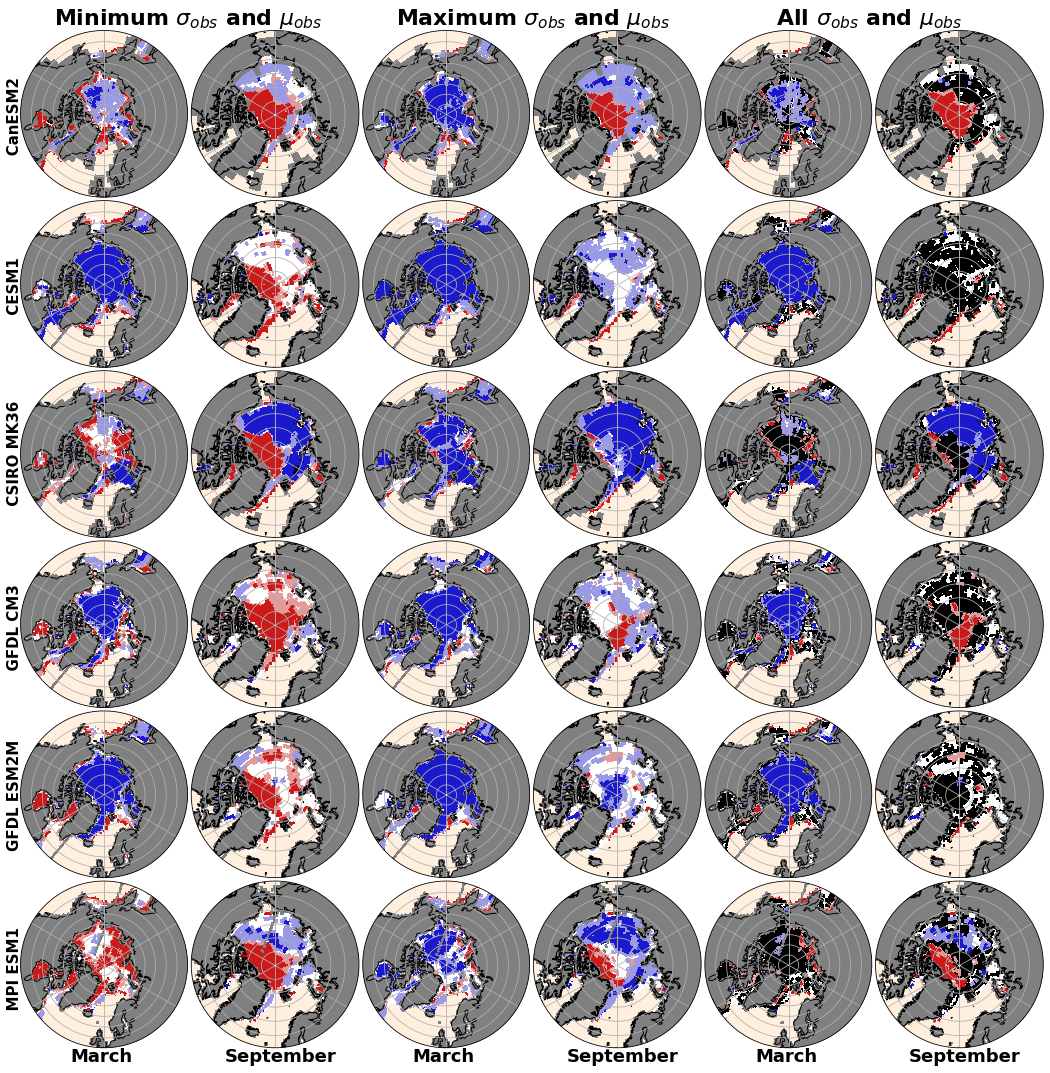

In [29]:
#plot 6x6
fig = plt.figure(figsize=[18,18])

for dataset in range(3):
    
    for model_i, model_name in enumerate(model_names):
        for month_i, month_ in enumerate([3,9]):

            i = (model_i*2) + month_i + 1
            if month_ == 3:
                lat_min = 50
            else:
                lat_min = 60

            ax = fig.add_subplot(6,6,i+(model_i*4 + dataset*2), projection = ccrs.NorthPolarStereo(central_longitude=0))
            ax.set_extent((-180,180,lat_min,90), ccrs.PlateCarree())

            #set boundary of subplots
            theta = np.linspace(0, 2*np.pi, 100) #make the plot circular
            center, radius = [0.5, 0.5], 0.5
            verts = np.vstack([np.sin(theta), np.cos(theta)]).T
            circle = mpath.Path(verts * radius + center)
            ax.set_boundary(circle, transform=ax.transAxes)
            ax.set_facecolor('1')
            
            #plot in sequence: red (too high), blue (too low), black (disagreement), baige (no sea ice), gray (land)
            #black - disagreement
            black_list[dataset].sel(model=model_name).sel(month=month_).plot(colors='0', levels=[1,2], add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face')            
            #light red - too high in one metric
            l_red_list[dataset].sel(model=model_name).sel(month=month_).plot(colors=[(0.9, 0.6, 0.6)], levels=[1,2], add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face')
            #red - too high
            red_list[dataset].sel(model=model_name).sel(month=month_).plot(colors=[(0.8, 0.1, 0.1)], levels=[1,2], add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face')
            #light blue - too low in one metric
            l_blue_list[dataset].sel(model=model_name).sel(month=month_).plot(colors=[(0.6, 0.6, 0.9)], levels=[1,2], add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face')
            #blue - too low
            blue_list[dataset].sel(model=model_name).sel(month=month_).plot(colors=[(0.1, 0.1, 0.8)], levels=[1,2], add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face')
            #baige - no sea ice 
            no_ice_list[dataset].sel(model=model_name).sel(month=month_).plot(cmap='Oranges', levels=np.arange(0.9,3,0.1), add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face')
            #gray - land 
            xr.ufuncs.isnan(masks_copied[model_name]).plot(colors='0.5', levels=[1,2], add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face')
            
            ax.coastlines()
            ax.gridlines()

            if i == 1:    
                ax.text(0.2, 1.14, titles_datasets[dataset], fontsize=22, fontweight='bold', transform=ax.transAxes, va='top', ha='left');
            elif i == 12:
                ax.text(0.2, 0, 'September', fontsize=18, fontweight='bold', transform=ax.transAxes, va='top', ha='left');
            elif i == 11:
                ax.text(0.3, 0, 'March', fontsize=18, fontweight='bold', transform=ax.transAxes, va='top', ha='left');
            
            if (i+(model_i*4 + dataset*2)-1) % 6 == 0:
                ax.text(-0.08, 0.16, model_names_center[model_i], fontsize=15, fontweight='bold', transform=ax.transAxes, va='bottom', ha='left', rotation='vertical');
                

fig.subplots_adjust(top=0.91, left=0.02, hspace=0.02, wspace=-0.4);
fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIC/figures/Resampled_figures_SIC_Consistency_6x6_min_max_with_light_no_lines.pdf', bbox_inches = 'tight', pad_inches = 0)
# fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIC/figures/Resampled_figures_SIC_Consistency_6x6_min_max_with_light.png', bbox_inches = 'tight', pad_inches = 0, dpi=300)

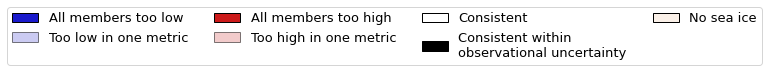

In [251]:
fig = plt.figure(figsize=[0.01,0.01])
legend_elements = [Patch(facecolor=(0.1, 0.1, 0.8), ec='0', label='All members too low'),
                   Patch(facecolor=(0.6, 0.6, 0.9), ec='0', alpha=0.5, label='Too low in one metric'),
                   Patch(facecolor=(0.8, 0.1, 0.1), ec='0', label='All members too high'),
                   Patch(facecolor=(0.9, 0.6, 0.6), ec='0', alpha=0.5, label='Too high in one metric'),
                   Patch(facecolor='1', ec='0', label='Consistent'),
                   Patch(facecolor='0', ec='0', label='Consistent within \n'+'observational uncertainty'),
                   Patch(facecolor=(0.98,0.94,0.91), ec='0', label='No sea ice')]

plt.legend(handles=legend_elements, bbox_to_anchor=(0, 0), loc='lower left', borderaxespad=0., ncol=4, fontsize=13)
plt.gca().set_axis_off()
fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIC/figures/Resampled_figures_SIC_Consistency_6x6_legend.pdf', bbox_inches = 'tight', pad_inches = 0)

## For Poster

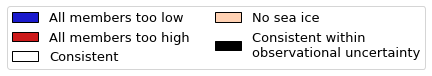

In [30]:
fig = plt.figure(figsize=[0.01,0.01])
legend_elements = [Patch(facecolor=(0.1, 0.1, 0.8), ec='0', label='All members too low'),
                   Patch(facecolor=(0.8, 0.1, 0.1), ec='0', label='All members too high'),
                   Patch(facecolor='1', ec='0', label='Consistent'),
                   # Patch(facecolor=(0.98,0.94,0.91), ec='0', label='No sea ice'),
                   Patch(facecolor=(1,0.82,0.70), ec='0', label='No sea ice'),
                   Patch(facecolor='0', ec='0', label='Consistent within \n'+'observational uncertainty')]

plt.legend(handles=legend_elements, bbox_to_anchor=(0, 0), loc='lower left', borderaxespad=0., ncol=2, fontsize=13)
plt.gca().set_axis_off()
fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIC/figures/Resampled_figures_SIC_Consistency_legend_talk.pdf', bbox_inches = 'tight', pad_inches = 0)

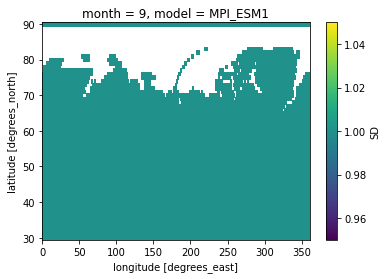

In [17]:
no_ice_list[dataset].where(no_ice_list[dataset]).sel(model=model_name).sel(month=month_).plot()

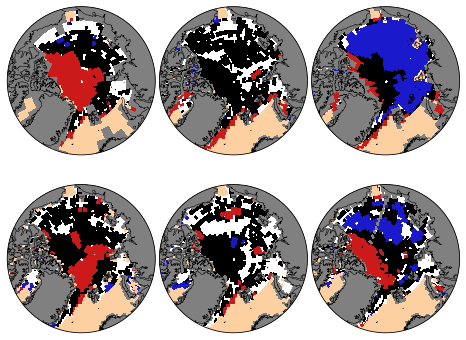

In [29]:
#plot 2x3
fig = plt.figure(figsize=[10,6])

dataset = 2 
month_ = 9
lat_min = 67.5
    
for model_i, model_name in enumerate(model_names):
        
    ax = fig.add_subplot(2,3,model_i+1, projection = ccrs.NorthPolarStereo())
    ax.set_extent((-180,180,lat_min,90), ccrs.PlateCarree())

    #set boundary of subplots
    theta = np.linspace(0, 2*np.pi, 100) #make the plot circular
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_facecolor('1')

    #plot in sequence: red (too high), blue (too low), black (disagreement), baige (no sea ice), gray (land)
    #black - disagreement
    black_list[dataset].sel(model=model_name).sel(month=month_).plot(colors='0', levels=[1,2], add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face')            
    #light red - too high in one metric
    l_red_list[dataset].sel(model=model_name).sel(month=month_).plot(colors=[(0.8, 0.1, 0.1)], levels=[1,2], add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face') 
    #red - too high
    red_list[dataset].sel(model=model_name).sel(month=month_).plot(colors=[(0.8, 0.1, 0.1)], levels=[1,2], add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face') 
    #light blue - too low in one metric
    l_blue_list[dataset].sel(model=model_name).sel(month=month_).plot(colors=[(0.1, 0.1, 0.8)], levels=[1,2], add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face') 
    #blue - too low
    blue_list[dataset].sel(model=model_name).sel(month=month_).plot(colors=[(0.1, 0.1, 0.8)], levels=[1,2], add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face') 
    #baige - no sea ice 
    # no_ice_list[dataset].sel(model=model_name).sel(month=month_).plot(cmap='Oranges', levels=np.arange(0.9,3,0.1), add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face') 
    no_ice_list[dataset].sel(model=model_name).sel(month=month_).plot(cmap='Oranges', levels=np.arange(0.9,1.5,0.1), add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face') 
    # no_ice_list[dataset].where(no_ice_list[dataset]).sel(model=model_name).sel(month=month_).plot(colors='none', hatches=[None, 'xxxx'], levels=np.arange(0.9,3,0.1), add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face') 
    # ax.contourf(no_ice_list[dataset]['lon'], no_ice_list[dataset]['lat'], no_ice_list[dataset].sel(model=model_name).sel(month=month_), colors='none', hatches=['xxxx'], zorder=1, transform=ccrs.PlateCarree())
    #gray - land 
    xr.ufuncs.isnan(masks_copied[model_name]).plot(colors='0.5', levels=[1,2], add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face') 

    ax.coastlines(lw=0.5)

fig.subplots_adjust(hspace=0.2, wspace=-0.4);
fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIC/figures/Resampled_figures_SIC_Consistency_for_colloquium_sep.pdf', bbox_inches = 'tight', pad_inches = 0)